<a href="https://colab.research.google.com/github/Masao-Taketani/various_GANs_analysis/blob/master/cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, LeakyReLU,\
    ReLU, Conv2DTranspose, Dropout, concatenate, ZeroPadding2D, Input
from tensorflow.keras.activations import tanh
from tensorflow.keras.optimizers import Adam

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
dataset, metadata = tfds.load("cycle_gan/horse2zebra",
                              with_info=True,
                              as_supervised=True)

train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

In [4]:
metadata

tfds.core.DatasetInfo(
    name='cycle_gan',
    version=2.0.0,
    description='A dataset consisting of images from two classes A and B (For example: horses/zebras, apple/orange,...)',
    homepage='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=2661,
    splits={
        'testA': 120,
        'testB': 140,
        'trainA': 1067,
        'trainB': 1334,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/ZhuPIE17,
      author    = {Jun{-}Yan Zhu and
                   Taesung Park and
                   Phillip Isola and
                   Alexei A. Efros},
      title     = {Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial
                   Networks},
      journal   = {CoRR},
      volume    = {abs/1703.10593},

In [5]:
def count_size(dataset):
  ct = 0
  for _ in dataset.as_numpy_iterator():
    ct += 1

  return ct

def random_crop(img):
  cropped_img = tf.image.random_crop(img,
                                     size=[HEIGHT, WIDTH, 3])
  
  return cropped_img

# to normalize an image to [-1, 1]
def normalize(img):
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  return img

def random_jitter(img):
  # to resize an image to 286 x 286 x 3
  img = tf.image.resize(img,
                        [286, 286],
                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # to randomly crop an image to 256 x 256 x 3
  img = random_crop(img)
  # to randomly mirror an image
  img = tf.image.random_flip_left_right(img)

  return img

def preprocess_img_train(img, label):
  img = random_jitter(img)
  img = normalize(img)

  return img

def preprocess_img_test(img, label):
  img = normalize(img)

  return img

def normalize_to_zero_one(img):
  return img * 0.5 + 0.5

def plot_sample_img(img, kind):
  jittered_img = random_jitter(img)
  plt.subplot(121)
  plt.title(kind)
  plt.imshow(normalize_to_zero_one(img))

  plt.subplot(122)
  plt.title("{} with random jitter".format(kind))
  plt.imshow(normalize_to_zero_one(jittered_img))

In [6]:
BUFFER_SIZE = count_size(train_horses)
BATCH_SIZE = 1
WIDTH = 256
HEIGHT = 256
INPUT_SHAPE = (256, 256, 3)

In [7]:
train_horses = train_horses.map(preprocess_img_train,
                                num_parallel_calls=AUTOTUNE).cache().shuffle(
                                    BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras = train_zebras.map(preprocess_img_train,
                                num_parallel_calls=AUTOTUNE).cache().shuffle(
                                    BUFFER_SIZE).batch(BATCH_SIZE)
test_horses = test_horses.map(preprocess_img_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(
                                  BUFFER_SIZE).batch(BATCH_SIZE)
test_zebras = test_zebras.map(preprocess_img_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(
                                  BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

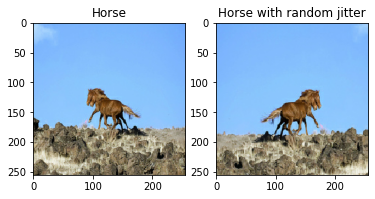

In [9]:
plot_sample_img(sample_horse[0], "Horse")

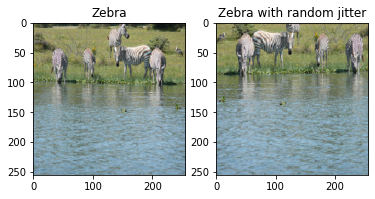

In [10]:
plot_sample_img(sample_zebra[0], "Zebra")

# CycleGAN Modules

In [11]:
class InstanceNormalization(Layer):
    """
    Instance Normalization Layer (https://arxiv.org/abs/1607.08022).

    Args:
        epsilon: a small positive decimal number to avoid dividing by 0
    """

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(name="scale",
                                     shape=input_shape[-1:],
                                     initializer=tf.random_normal_initializer(0., 0.02),
                                     trainable=True)

        self.offset = self.add_weight(name="offset",
                                      shape=input_shape[-1:],
                                      initializer="zeros",
                                      trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset


class ResNetBlock(Layer):
    # Define ResNet block

    def __init__(self,
                 filters, 
                 size=3, 
                 strides=1, 
                 padding="valid", 
                 name="resnetblock"):

        super(ResNetBlock, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)
        self.size = size
        self.conv2d_1 = Conv2D(filters, 
                               size, 
                               strides, 
                               padding=padding,
                               kernel_initializer=initializer,
                               use_bias=False)
        self.instance_norm_1 = InstanceNormalization()
        self.ReLU = ReLU()
        self.conv2d_2 = Conv2D(filters,
                               size,
                               strides,
                               padding=padding,
                               kernel_initializer=initializer,
                               use_bias=False)
        self.instance_norm_2 = InstanceNormalization()

        
    def call(self, inputs):
        pad = int((self.size - 1) / 2)
        # Reflection padding was used to reduce artifacts
        x = tf.pad(inputs, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "REFLECT")
        x = self.conv2d_1(x)
        x = self.instance_norm_1(x)
        x = self.ReLU(x)
        x = tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "REFLECT")
        x = self.conv2d_2(x)
        x = self.instance_norm_2(x)
        return x + inputs


def get_norm_layer(norm_type):
    if norm_type.lower() == "batchnorm":
        return BatchNormalization()
    elif norm_type.lower() == "instancenorm":
        return InstanceNormalization()
    else:
        raise ValueError("arg `norm_type` has to be either batchnorm "
                         "or instancenorm. What you specified is "
                         "{}".format(norm_type))


def get_activation(activation):
    if activation.lower() == "relu":
        return ReLU()
    elif activation.lower() == "lrelu":
        return LeakyReLU(0.2)
    elif activation.lower() == "tanh":
        return tanh
    else:
        raise ValueError("arg `norm_type` has to be either relu "
                         "or tanh. What you specified is "
                         "{}".format(norm_type))


class Downsample(Layer):
    """
     Conv2D -> BatchNorm(or InstanceNorm) -> LeakyReLU

     Args:
        filters: number of filters
           size: filter size
      norm_type: normalization type. Either "batchnorm", "instancenorm" or None
           name: name of the layer

    Return:
        Downsample functional model
    """

    def __init__(self, 
                 filters, 
                 size,
                 strides=1,
                 padding="same",
                 norm_type="batchnorm",
                 activation="lrelu",
                 name="downsample", 
                 **kwargs):

        super(Downsample, self).__init__(name=name, **kwargs)
        initializer = tf.random_normal_initializer(0., 0.02)
        self.norm_type = norm_type
        use_bias = False
        if self.norm_type:
            self.norm_layer = get_norm_layer(norm_type)
        else:
            use_bias = True
        self.conv2d = Conv2D(filters,
                             size,
                             strides=strides,
                             padding=padding,
                             kernel_initializer=initializer,
                             use_bias=use_bias)
        self.activation = get_activation(activation)

    def call(self, inputs):
        x = self.conv2d(inputs)
        if self.norm_type:
            x = self.norm_layer(x)
        x = self.activation(x)

        return x


class Upsample(Layer):
    """
    Conv2DTranspose -> BatchNorm(or InstanceNorm) -> Dropout -> ReLU

     Args:
        filters: number of filters
           size: filter size
      norm_type: normalization type. Either "batchnorm", "instancenorm" or None
  apply_dropout: If True, apply the dropout layer
           name: name of the layer

    Return:
        Upsample functional model
    """
    def __init__(self, 
                 filters, 
                 size,
                 strides,
                 padding,
                 norm_type="batchnorm",
                 apply_dropout=False,
                 activation="relu",
                 name="upsample", 
                 **kwargs):

        super(Upsample, self).__init__(name=name, **kwargs)
        initializer = tf.random_normal_initializer(0., 0.02)
        self.norm_type = norm_type
        use_bias = False
        if self.norm_type:
            self.norm_layer = get_norm_layer(norm_type)
        else:
            use_bias = True
        self.apply_dropout = apply_dropout
        self.conv2dtranspose = Conv2DTranspose(filters,
                                               size,
                                               strides=strides,
                                               padding=padding,
                                               kernel_initializer=initializer,
                                               use_bias=use_bias)
        if apply_dropout:
            self.dropout = Dropout(0.5)
        self.activation = get_activation(activation)

    def call(self, inputs):
        x = self.conv2dtranspose(inputs)
        if self.norm_type:
            x = self.norm_layer(x)
        if self.apply_dropout:
            x = self.dropout(x)
        x = self.activation(x)

        return x


class Discriminator(Model):
    """
    PatchGan discriminator model (https://arxiv.org/abs/1611.07004).

    Referred from CycleGAN paper(https://arxiv.org/abs/1703.10593).
    For discriminator networks, we use 70 × 70 PatchGAN. Let Ck denote a
    4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k
    filters and stride 2. After the last layer, we apply a convolution to produce 
    a 1-dimensional output. We do not use
    InstanceNorm for the first C64 layer. We use leaky ReLUs
    with a slope of 0.2. The discriminator architecture is:
    C64-C128-C256-C512

    Args:
        norm_type: normalization type. Either "batchnorm", "instancenorm" or None
           target: Bool, indicating whether the target image is an input or not

    Return:
        Discriminator model
    """
    def __init__(self,
                 first_filters=64,
                 size=4,
                 norm_type="instancenorm", 
                 name="discriminator",
                 **kwargs):

        super(Discriminator, self).__init__(name=name, **kwargs)
        initializer = tf.random_normal_initializer(0., 0.02)
        self.norm_type = norm_type
        self.downsample_1 = Downsample(first_filters, 
                                       size,
                                       strides=2,
                                       padding="same",
                                       norm_type=None,
                                       activation="lrelu",
                                       name="downsample_1")
        self.downsample_2 = Downsample(first_filters * 2, 
                                       size,
                                       strides=2,
                                       padding="same",
                                       norm_type=norm_type,
                                       activation="lrelu",
                                       name="downsample_2")
        self.downsample_3 = Downsample(first_filters * 4, 
                                       size,
                                       strides=2,
                                       padding="same",
                                       norm_type=norm_type,
                                       activation="lrelu",
                                       name="downsample_3")
        self.zeropadding2d_1 = ZeroPadding2D()
        self.downsample_4 = Downsample(first_filters * 8, 
                                       size, 
                                       strides=1,
                                       padding="valid",
                                       norm_type=norm_type,
                                       activation="lrelu",
                                       name="downsample_4")
        self.zeropadding2d_2 = ZeroPadding2D()
        self.conv2d = Conv2D(1, 
                             size, 
                             strides=1,
                             padding="valid",
                             kernel_initializer=initializer)

    def call(self, inputs):
        # inputs: (bs, 256, 256, input channels)
        x = self.downsample_1(inputs) # (bs, 128, 128, first_filters)
        x = self.downsample_2(x) # (bs, 64, 64, first_filters * 2)
        x = self.downsample_3(x) # (bs, 32, 32, first_filters * 4)
        x = self.zeropadding2d_1(x) # (bs, 34, 34, first_filters * 4)
        x = self.downsample_4(x) # (bs, 31, 31, first_filters * 8)
        x = self.zeropadding2d_2(x) # (bs, 33, 33, first_filters * 8)
        result = self.conv2d(x) # (bs, 30, 30, 1)

        return result

    def summary(self):
        x = Input(shape=INPUT_SHAPE)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()


class ResNetGenerator(Model):
    """
    Referred from CycleGAN paper(https://arxiv.org/abs/1703.10593).
    Let c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters 
    and stride 1. dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with 
    k filters and stride 2. Reflection padding was used to reduce artifacts.
    Rk denotes a residual block that contains two 3 × 3 convolutional layers 
    with the same number of filters on both layer. 
    uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer 
    with k filters and stride 1/2.

    The network with 6 residual blocks consists of:
        c7s1-64,d128,d256,R256,R256,R256,
        R256,R256,R256,u128,u64,c7s1-3

    The network with 9 residual blocks consists of:
        c7s1-64,d128,d256,R256,R256,R256,
        R256,R256,R256,R256,R256,R256,u128
        u64,c7s1-3

    Args:
    output_channels: number of output channels
          norm_type: normalization type. Either "batchnorm", "instancenorm" or None

    Return:
        Generator model
    """
    def __init__(self,
                 first_filters=64,
                 output_channels=3,
                 norm_type="instancenorm", 
                 name="resnet_generator",
                 **kwargs):

        super(ResNetGenerator, self).__init__(name=name, **kwargs)
        initializer = tf.random_normal_initializer(0., 0.02)
        self.downsample_1 = Downsample(first_filters, 
                                       7,
                                       strides=1,
                                       padding="valid",
                                       norm_type="instancenorm", 
                                       name="downsample_1")
        self.downsample_2 = Downsample(first_filters*2, 
                                       3,
                                       strides=2,
                                       norm_type="instancenorm", 
                                       name="downsample_2")
        self.downsample_3 = Downsample(first_filters*4, 
                                       3,
                                       strides=2,
                                       norm_type="instancenorm", 
                                       name="downsample_3")
        self.resnetblock_1 = ResNetBlock(first_filters*4, name="resnetblock_1")
        self.resnetblock_2 = ResNetBlock(first_filters*4, name="resnetblock_2")
        self.resnetblock_3 = ResNetBlock(first_filters*4, name="resnetblock_3")
        self.resnetblock_4 = ResNetBlock(first_filters*4, name="resnetblock_4")
        self.resnetblock_5 = ResNetBlock(first_filters*4, name="resnetblock_5")
        self.resnetblock_6 = ResNetBlock(first_filters*4, name="resnetblock_6")
        self.resnetblock_7 = ResNetBlock(first_filters*4, name="resnetblock_7")
        self.resnetblock_8 = ResNetBlock(first_filters*4, name="resnetblock_8")
        self.resnetblock_9 = ResNetBlock(first_filters*4, name="resnetblock_9")
        self.upsample_1 = Upsample(first_filters*2, 
                                   3,
                                   2,
                                   padding="same",
                                   norm_type="instancenorm",
                                   name="upsample_1")
        self.upsample_2 = Upsample(first_filters, 
                                   3,
                                   2,
                                   padding="same",
                                   norm_type="instancenorm",
                                   name="upsample_2")
        self.last_conv2d = Conv2D(output_channels, 
                                  7,
                                  1,
                                  padding="valid",
                                  activation="tanh",
                                  name="last_conv2d")

    def call(self, inputs):
        # Reflection padding was used to reduce artifacts
        x = tf.pad(inputs, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        x = self.downsample_1(x)
        x = self.downsample_2(x)
        x = self.downsample_3(x)
        x = self.resnetblock_1(x)
        x = self.resnetblock_2(x)
        x = self.resnetblock_3(x)
        x = self.resnetblock_4(x)
        x = self.resnetblock_5(x)
        x = self.resnetblock_6(x)
        x = self.resnetblock_7(x)
        x = self.resnetblock_8(x)
        x = self.resnetblock_9(x)
        x = self.upsample_1(x)
        x = self.upsample_2(x)
        x = tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        result = self.last_conv2d(x)

        return result

    """
    model func is created to check and debug the model architecture.
    Referred from 
    https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model
    """
    def summary(self):
        x = Input(shape=INPUT_SHAPE)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [12]:
gene_h2z = ResNetGenerator(name="generator_h2z")
gene_z2h = ResNetGenerator(name="generator_z2h")

disc_h = Discriminator(name="discriminator_h")
disc_z = Discriminator(name="discriminator_z")

In [13]:
gene_h2z.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.compat.v1.pad (TFOpLambda (None, 262, 262, 3)       0         
_________________________________________________________________
downsample_1 (Downsample)    (None, 256, 256, 64)      9536      
_________________________________________________________________
downsample_2 (Downsample)    (None, 128, 128, 128)     73984     
_________________________________________________________________
downsample_3 (Downsample)    (None, 64, 64, 256)       295424    
_________________________________________________________________
res_net_block (ResNetBlock)  (None, 64, 64, 256)       1180672   
_________________________________________________________________
res_net_block_1 (ResNetBlock (None, 64, 64, 256)       118067

In [14]:
disc_h.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
downsample_1 (Downsample)    (None, 128, 128, 64)      3136      
_________________________________________________________________
downsample_2 (Downsample)    (None, 64, 64, 128)       131328    
_________________________________________________________________
downsample_3 (Downsample)    (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
downsample_4 (Downsample)    (None, 31, 31, 512)       2098176   
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 33, 33, 512)       0   

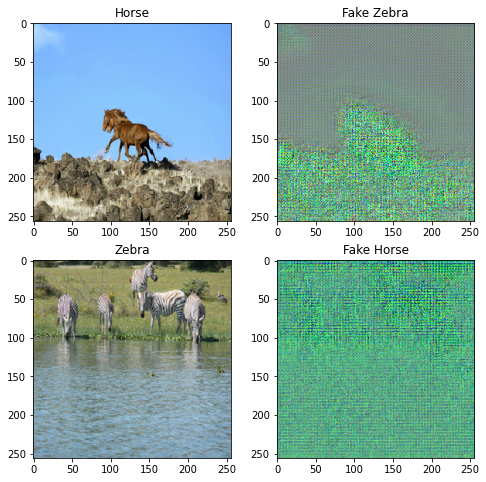

In [15]:
fake_zebra = gene_h2z(sample_horse)
fake_horse = gene_z2h(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 32

imgs = [sample_horse, fake_zebra, sample_zebra, fake_horse]
titles = ["Horse", "Fake Zebra", "Zebra", "Fake Horse"]

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(titles[i])
  if i % 2 == 0:
    # need [0] for imgs[i] to make it 3 dimentions (h, w, c)
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

plt.show()

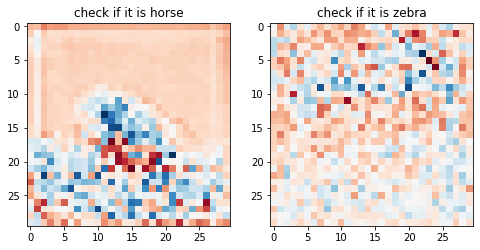

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title("check if it is horse")
# since shape of disc_h(sample_horse) is (1, 30, 30, 1),
# need [0, ..., 0] for disc_h(sample_horse) to make it (30, 30)
plt.imshow(disc_h(sample_horse)[0, ..., 0], cmap="RdBu_r")

plt.subplot(122)
plt.title("check if it is zebra")
plt.imshow(disc_z(sample_zebra)[0, ..., 0], cmap="RdBu_r")

plt.show()

In [17]:
disc_h(sample_horse)[0, ..., 0].shape

TensorShape([30, 30])

# Loss Functions

In [18]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_img, cycled_img):
  loss = tf.reduce_mean(tf.abs(real_img - cycled_img))
  return LAMBDA * loss

def identity_loss(real_img, identity_img):
  loss = tf.reduce_mean(tf.abs(real_img - identity_img))
  return LAMBDA * 0.5 * loss

In [19]:
gene_h2z_opt = Adam(2e-4, beta_1=0.5)
gene_z2h_opt = Adam(2e-4, beta_1=0.5)

disc_h_opt = Adam(2e-4, beta_1=0.5)
disc_z_opt = Adam(2e-4, beta_1=0.5)

# Checkpoints

In [20]:
checkpoint_path = "ckpts/train"

ckpt = tf.train.Checkpoint(gene_h2z=gene_h2z,
                           gene_z2h=gene_z2h,
                           disc_h=disc_h,
                           disc_z=disc_z,
                           gene_h2z_opt=gene_h2z_opt,
                           gene_z2h_opt=gene_z2h_opt,
                           disc_h_opt=disc_h_opt,
                           disc_z_opt=disc_z_opt)

ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored.")

# Training

In [21]:
def generate_imgs(model, test_input):
  pred = model(test_input)

  plt.figure(figsize=(12, 12))

  img_list = [test_input[0], pred[0]]
  titles = ["Input Image", "Predicted Image"]

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    plt.imshow(img_list[i] * 0.5 + 0.5)
    plt.axis("off")
  plt.show()

In [22]:
@tf.function
def train_step(real_h, real_z):
  # persistent is set to True because the tape is used more than
  # onece to calculate the gradients
  with tf.GradientTape(persistent=True) as tape:
    fake_z = gene_h2z(real_h, training=True)
    cycled_h = gene_z2h(fake_z, training=True)

    fake_h = gene_z2h(real_z, training=True)
    cycled_z = gene_h2z(fake_h, training=True)

    # same_h and same_z are used for identity loss
    identity_h = gene_z2h(real_h, training=True)
    identity_z = gene_h2z(real_z, training=True)

    disc_real_h = disc_h(real_h, training=True)
    disc_real_z = disc_z(real_z, training=True)

    disc_fake_h = disc_h(fake_h, training=True)
    disc_fake_z = disc_z(fake_z, training=True)

    # calcuate the loss
    gene_h2z_loss = generator_loss(disc_fake_z)
    gene_z2h_loss = generator_loss(disc_fake_h)
    total_cycle_loss = cycle_loss(real_h, cycled_h) + cycle_loss(real_z, cycled_z)
    id_h_loss = identity_loss(real_h, identity_h)
    id_z_loss = identity_loss(real_z, identity_z)
    # Total generator loss = adversarial loss + cycle loss + identity loss
    total_gene_h2z_loss = gene_h2z_loss + total_cycle_loss + id_z_loss
    total_gene_z2h_loss = gene_z2h_loss + total_cycle_loss + id_h_loss

    disc_h_loss = discriminator_loss(disc_real_h, disc_fake_h)
    disc_z_loss = discriminator_loss(disc_real_z, disc_fake_z)

  # Calcuate the gradients for the generators and discriminators
  gene_h2z_gradients = tape.gradient(total_gene_h2z_loss, gene_h2z.trainable_variables)
  gene_z2h_gradients = tape.gradient(total_gene_z2h_loss, gene_z2h.trainable_variables)
  disc_h_gradients = tape.gradient(disc_h_loss, disc_h.trainable_variables)
  disc_z_gradients = tape.gradient(disc_z_loss, disc_z.trainable_variables)

  # Apply the gradients to the optimizer
  gene_h2z_opt.apply_gradients(zip(gene_h2z_gradients, gene_h2z.trainable_variables))
  gene_z2h_opt.apply_gradients(zip(gene_z2h_gradients, gene_z2h.trainable_variables))
  disc_h_opt.apply_gradients(zip(disc_h_gradients, disc_h.trainable_variables))
  disc_z_opt.apply_gradients(zip(disc_z_gradients, disc_z.trainable_variables))

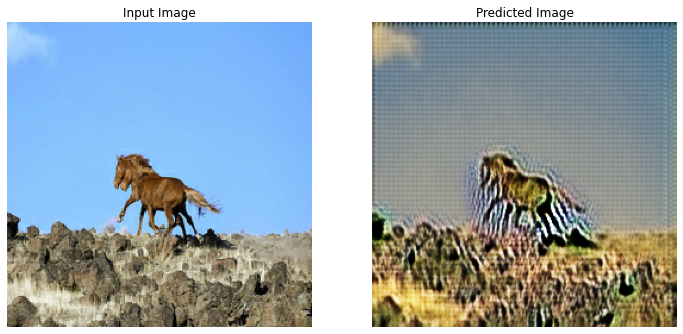

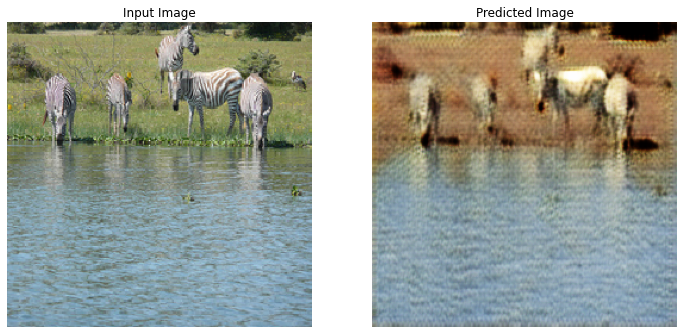

Time taken for epoch 1 is 5578.06746339798 sec

.

KeyboardInterrupt: 

In [23]:
EPOCHS = 200

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for img_h, img_z in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(img_h, img_z)
    if n % 10 == 0:
      print(".", end="")
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_imgs(gene_h2z, sample_horse)
  generate_imgs(gene_z2h, sample_zebra)

  print("Time taken for epoch {} is {} sec\n".format(epoch+1, time.time()-start))

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print("Saving a checkpoint for epoch {} at {}".format(epoch+1, ckpt_save_path))

In [ ]:
!nvidia-smi